# DeepProbLog Assignment #

DeepProbLog is an extension of ProbLog that integrates Probabilistic Logic Programming with deep learning by means of neural predicates.

The aim of this project is to show how to solve AI tasks that require the integration of high-level reasoning and low-level perception. We focus on the multi-digit MNIST octal-division task that consists in computing the division between two lists of MNIST digits representing multi-digit octal numbers. Using
DeepProbLog we are able to solve the task given that supervision is only present at the output side of the probabilistic reasoner and considering that the approach can be extended to multi-digit numbers without being explicitly trained on them.

## DeepProbLog Installation ##

DeepProbLog can be installed as follows.

In [ ]:
!git clone https://bitbucket.org/problog/deepproblog/
!cp -R deepproblog/archived/* .
!pip3 install PySDD
!pip3 install problog

Cloning into 'deepproblog'...
Receiving objects: 100% (267/267), 2.09 MiB | 5.38 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 6.8 MB/s 
  Created wheel for PySDD: filename=PySDD-0.2.10-cp37-cp37m-linux_x86_64.whl size=2324489 sha256=c31c0b7006ff63836931a23a68daa102f6b23e694cb4f1b843ec7fe79eca7446
  Stored in directory: /root/.cache/pip/wheels/4f/d0/30/f01a26723750159dae4b464a9b9ca45e2aea4941f90f6fc394
Successfully built PySDD
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.9 MB/s 
  Created wheel for problog: filename=problog-2.2.3-py3-none-any.whl size=1297540 sha256=df9b7a18f07ecb4f759229eb7f8952a9ca46ce7a300020c42de0bf89e0ff7f8d
  Stored in directory: /root/.cache/pip/wheels/2d/e1/a0/3ac56c18f82cd3e8e2b4e232a2a1e858531638903c035f3ca6
S

## Multi-digit MNIST octal-division task ##

The multi-digit MNIST octal-division task is a problem in
machine learning that involves dividing two multi-digit octal
numbers. The problem is to predict the quotient of the division.

In [ ]:
!mkdir project

The DeepProbLog program proceeds building the base-10 dividend and divisor from the list of MNIST images. Then the division can be calculated applying the standard Prolog operator for the integer division between decimal numbers and the result converted back to a base-8 number.

```prolog
nn(mnist_net,[X],Y,[0,1,2,3,4,5,6,7]) :: digit(X,Y).

number([],Result,Result).
number([H|T],Acc,Result) :- digit(H,Nr),
                            Acc2 is Nr+8*Acc,
                            number(T,Acc2,Result).
number(X,Y) :- number(X,0,Y).

dec2oct(0,0).
dec2oct(S,X) :- X > 0 ,
               X1 is X // 8 ,
               dec2oct(S1,X1),  
               S0 is X mod 8 ,
               S is S0 + S1 * 10 .

division(X,Y,Z) :- number(X,Xdec),
                  number(Y,Ydec),
                  Ydec > 0,
                  Zdec is Xdec//Ydec,
                  dec2oct(Z, Zdec).
```

In [ ]:
problog_string = '''
nn(mnist_net,[X],Y,[0,1,2,3,4,5,6,7]) :: digit(X,Y).

number([],Result,Result).
number([H|T],Acc,Result) :- digit(H,Nr),
                            Acc2 is Nr+8*Acc,
                            number(T,Acc2,Result).
number(X,Y) :- number(X,0,Y).

dec2oct(0,0).
dec2oct(S,X) :- X > 0 ,
               X1 is X // 8 ,
               dec2oct(S1,X1),
               S0 is X mod 8 ,
               S is S0 + S1 * 10 .

division(X,Y,Z) :- number(X,Xdec),
                  number(Y,Ydec),
                  Ydec > 0,
                  Zdec is Xdec//Ydec,
                  dec2oct(Z, Zdec).
'''

prolog_file = "project/division.pl"
with open(prolog_file, "w") as f:
  f.write(problog_string)

Download MNIST training and test sets.

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

mnist_train_data = MNIST(root='data/MNIST', train=True, download=True, transform=transform)
mnist_test_data = MNIST(root='data/MNIST', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



Starting from the MNIST dataset we construct the training and test sets as follows. The training set is composed of pair of images that represent single-digit base-8 numbers and the test set is composed of two lists of images that represent three-digit base-8 numbers. In both cases, the second number is a divisor of the first one.

Then, we create the queries files for both train and test sets, connecting MNIST images to instances of the `division` Prolog predicate.

In [ ]:
import random
random.seed(0)

def random_number(num_digits, digits):
  n = 0
  n_digits = list()
  indices = list()
  kk = list(digits.keys())
  for _ in range(num_digits):
    if len(kk) == 0:
        return None, None, n_digits

    d = random.choice(kk)
    i = digits[d].pop()
    if len(digits[d]) == 0:
        del digits[d]
        kk = list(digits.keys())

    n = n*10 + d
    n_digits.append((d, i))
    indices.append(i)

  return n, indices, n_digits

def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]

def random_divisor(n_dec, num_digits, digits):
    if n_dec == 0:
        divisor = random.randint(1, 8**num_digits-1)
    else:
        divisor_i = random.randint(1, n_dec)

        for inc in range(max(n_dec-divisor_i, divisor_i)+1):
            if n_dec % (divisor_i + inc) == 0:
                divisor = divisor_i + inc
                break

            if divisor_i - inc > 0 and n_dec % (divisor_i - inc) == 0:
                divisor = divisor_i - inc
                break

    divisor_octal_digits = numberToBase(divisor, 8)

    n_digits = list()
    indices = list()
    for d in divisor_octal_digits:
        if d not in digits:
            return None, None, n_digits

        i = digits[d].pop()
        n_digits.append((d, i))
        indices.append(i)
        if len(digits[d]) == 0:
            del digits[d]

    return divisor, indices, n_digits

def save_examples(dataset_name, examples, out):
    with open(out, 'w') as f:
        for example in examples:
            n1, nr1, n2, nr2, res = example
            # number encoded as e.g. (test(9150),test(6809),test(1586))
            args1 = tuple('{}({})'.format(dataset_name, e) for e in nr1)
            args2 = tuple('{}({})'.format(dataset_name, e) for e in nr2)
            # example encoded as e.g.
            # division([test(9150),test(6809),test(1586)], [test(114),test(2039),test(5872)], 1574).
            f.write('division([{}], [{}], {}).\n'.format(','.join(args1),
                                                         ','.join(args2),
                                                         res))

    with open(f"{out}.log", 'w') as f:
        for example in examples:
            n1, nr1, n2, nr2, res = example
            f.write(f'division({n1}, {n2}, {res}) ({nr1}, {nr2}).\n')

# dataset is the MNIST train or test dataset
# dataset_name is the name of the generated dataset
# num_digits is the number of digits to be used
# out is the output file name
def generate_examples(dataset, dataset_name, num_digits, out):
  indices = list(range(len(dataset)))
  random.shuffle(indices)

  digits = dict([(d,[]) for d in range(8)])
  for i in indices:
    _, d = dataset[i]
    if d < 8:
        digits[d].append(i)
  len_dataset = sum([len(ii) for d, ii in digits.items()])

  examples = list()
  used_digits = 0
  attempts = 0
  while True:
    n1, n1_indices, n1_digits = random_number(num_digits, digits)

    if n1 is not None:
        n1_dec = int(f"{n1}", 8)
        n2_dec, n2_indices, n2_digits = random_divisor(n1_dec, num_digits, digits)

    if n1 is None or n2_dec is None:
        # restore image indexes in digits dictionary
        remaining_digits = sum([len(ii) for d, ii in digits.items()])
        for d, i in n1_digits + n2_digits:
            if d not in digits:
                digits[d] = list()
            digits[d].append(i)

        attempts += 1
        if attempts > 1000:
            break
        else:
            continue

    attempts = 0
    used_digits += len(n1_indices) + len(n2_indices)
    remaining_digits = sum([len(ii) for d, ii in digits.items()])
    assert(len_dataset - (used_digits + remaining_digits) == 0)


    assert(n1_dec % n2_dec == 0)
    res = n1_dec//n2_dec

    n2_octal_digits = numberToBase(n2_dec, 8)
    n2 = int(''.join([f"{d}" for d in n2_octal_digits]), 10)

    res_octal_digits = numberToBase(res, 8)
    res_octal = int(''.join([f"{d}" for d in res_octal_digits]), 10)
    examples.append((n1, n1_indices, n2, n2_indices, res_octal))

  remaining_digits = sum([len(ii) for d, ii in digits.items()])
  print("MNIST dataset size", len_dataset)
  print("number of used images", used_digits)
  print("number of unused images", remaining_digits)
  print("generated dataset size", len(examples))
  assert(len_dataset - (used_digits + remaining_digits) == 0)

  save_examples(dataset_name, examples, out)

In [ ]:
generate_examples(mnist_train_data, 'train', 1, 'project/train.txt')

MNIST dataset 48200
remaining digits 2284
used digits 45916
generated dataset 22958


In [ ]:
generate_examples(mnist_test_data, 'test', 3, 'project/test.txt')

MNIST dataset 8017
remaining digits 182
used digits 7835
generated dataset 1462


We can now define a Python class implementing a standard CNN for MNIST images, and a neural predicate connecting the image id (as found in the query) to the corresponding image and sending it to the neural network.

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class MNIST_Net(nn.Module):
    def __init__(self, N=10):
        super(MNIST_Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2, 2), # 6 24 24 -> 6 12 12
            nn.ReLU(True),
            nn.Conv2d(6, 16, 5), # 6 12 12 -> 16 8 8
            nn.MaxPool2d(2, 2), # 16 8 8 -> 16 4 4
            nn.ReLU(True)
        )
        self.classifier =  nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, N),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.classifier(x)
        return x

def neural_predicate(network, i):
    # i is something like train(2764) or test(4052)
    dataset = str(i.functor)
    i = int(i.args[0])
    if dataset == 'train':
        d, l = mnist_train_data[i]
    elif dataset == 'test':
        d, l = mnist_test_data[i]
    d = Variable(d.unsqueeze(0))
    output = network.net(d)
    return output.squeeze(0)

In [ ]:
net = MNIST_Net(N=8)

Calculate the number of parameters of the neural network.

In [ ]:
def get_num_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
get_num_params(net)

44256

We can now load our datasets.

In [ ]:
from data_loader import load

train_queries = load('project/train.txt')
test_queries = load('project/test.txt')

Finally, we can create the network and the DeepProbLog model with the network as neural predicate, and train it as a standard torch model.

In [ ]:
from train import train_model
from network import Network
from model import Model
from optimizer import Optimizer

def test(model):
    # acc = model.accuracy(random.sample(test_queries, 500), test=True, verbose=False)
    acc = model.accuracy(test_queries, test=True, verbose=False)
    return acc

network = MNIST_Net(N=8)
# Network is a DeepProbLog class that wraps a pytorch networks and interfaces with ProbLog
net = Network(network, 'mnist_net', neural_predicate)
net.optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
# Model is a DeepProbLog class that combines reasoning via the ProbLog code
# and neural processing via a list of Network objects
model = Model(problog_string, [net], caching=False)
optimizer = Optimizer(model, 2)

logger = train_model(model, train_queries, nr_epochs=1, optimizer=optimizer, test_iter=1000, test=test, snapshot_iter=5000)

logger.write_to_file('project/logging')

Training for 1 epochs (22958 iterations).


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Accuracy 0.304
Epoch 1
Iteration:  100 	Average Loss:  1.4620366560466362
Iteration:  200 	Average Loss:  1.3234191849261316
Iteration:  300 	Average Loss:  1.4721534216111172
Iteration:  400 	Average Loss:  1.4279436961139922
Iteration:  500 	Average Loss:  1.072696443427312
Iteration:  600 	Average Loss:  1.0824257473732855
Iteration:  700 	Average Loss:  0.9527953544477438
Iteration:  800 	Average Loss:  0.8330988304929308
Iteration:  900 	Average Loss:  0.8165522250719079
Iteration:  1000 	Average Loss:  0.7812377352349071
Accuracy 0.342
Iteration:  1100 	Average Loss:  0.7404657663690439
Iteration:  1200 	Average Loss:  0.8038504338444001
Iteration:  1300 	Average Loss:  0.4891516060556483
Iteration:  1400 	Average Loss:  0.6258229404668263
Iteration:  1500 	Average Loss:  0.6366239720960217
Iteration:  1600 	Average Loss:  0.7496530075576102
Iteration:  1700 	Average Loss:  0.6866814527458283
Iteration:  1800 	Average Loss:  0.5197674277202253
Iteration:  1900 	Average Loss:  0.6

Read the log files generated during training that contain training and validation statistics.

In [ ]:
import pandas as pd
import os

def search_files(directory, startswith, endswith):
  ff = list()
  for f_name in os.listdir(directory):
      if f_name.startswith(startswith) and f_name.endswith(endswith):
          ff.append(os.path.join(directory, f_name))
  return ff

ff = search_files('project', startswith='logging', endswith='.log')
ff.sort()
log_filename = ff[-1]

df = pd.read_csv(log_filename)
print(df)

train_losses = df['loss'][df['loss'].notnull()]
train_losses_xx = df['i'][df['loss'].notnull()]
val_acc = df['Accuracy'][df['Accuracy'].notnull()]
val_acc_xx = df['i'][df['Accuracy'].notnull()]

         i  Accuracy         time      loss
0        1     0.304          NaN       NaN
1      100       NaN    60.770952  1.462037
2      200       NaN    74.221855  1.323419
3      300       NaN    87.115356  1.472153
4      400       NaN   100.936090  1.427944
..     ...       ...          ...       ...
225  22500       NaN  4077.085412  0.075446
226  22600       NaN  4089.828378  0.140734
227  22700       NaN  4102.750203  0.157320
228  22800       NaN  4116.846017  0.092667
229  22900       NaN  4129.500324  0.031616

[230 rows x 4 columns]


Plot the training loss and validation accuracy.

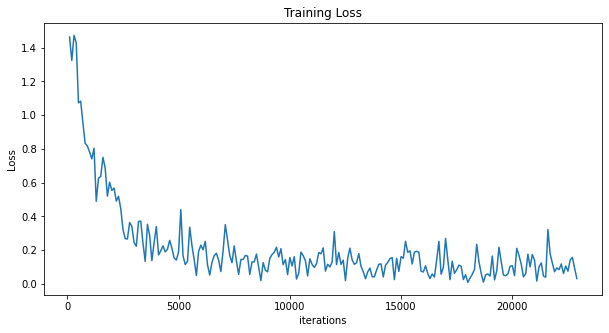

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses_xx, train_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

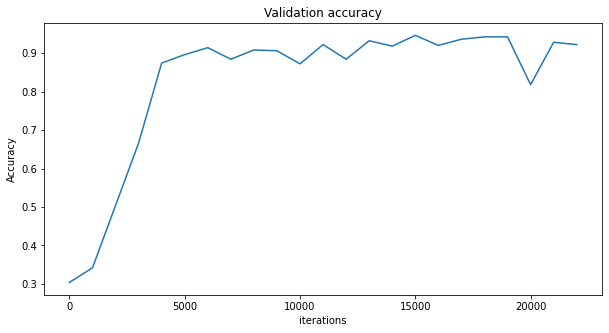

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation accuracy")
plt.plot(val_acc_xx, val_acc)
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.show()